# **Benchmark Demo**
**7/1**
<br>
Thoroughly benchmarking the **1D diffusion equation** will have a relatively low ROI. This is because the equation is simple enough that the PINN is actually a more tedious and very accurate of approximating the PDE. However, we should still scaffold how we're going to benchmark our solutions in the future. This is especially important because depending on the complexity of our PDE and our solving method, it may only be technically possible to benchmark a few different things for each equation. For instance, some of the equations we seek to evaluate in the future may not be able to be approximated without being simplified into a **toy model**, so our PINN wouldn't have a 1-to-1 comparison. We need to plan for these sorts of things. Furthermore, generally, we will want to target accuracy while also optimizing speed, but there may be instances where we build models that prioritize one over the other.
<br>
This will likely be done for both ease of computation **and** of visualization via **Pandas** dataframes.
<br><br>
If possible, we should benchmark a couple key traits
<br>
**Error:** We can solve PDEs for given points then compare the error percentage with the approximations at given points. We can also run computationally rigorous approximations for **some** PDEs and calculate a mean squared error (MSE) of the PINN solution, based on that.
<br>
**Runtime:** Straightfoward, we can factor in how long the approximation takes to complete. This will underscore the advantages of the PINN as we approximate over wider and wider points. This also opens up windows for optimizing the **hyperparameters** of the PINNs to create faster, more accurate models, comparing them side-by-side in our dataframe.
<br>
**Development Complexity:** Although this is purely qualitative, I think it should be important to note the development complexity and reproduction value. For instance, we can take a **toy model** of a system and calculate the losses like any other simple equation, but with a far more complex equation we may have to calculate **more losses**, **more complex losses**, and **assiduously iterate the parameters and hyperparameters**.
<br>
<br>
In later stages, parts of this notebook can later be packaged either into a standalone script or functions to be imported into an interactive notebook.

## **Benchmarking our 1D Diffusion Solvers**
We will be scaffolding our benchmarking tools with the data from our **1D Diffusion Solvers**. We will be handling each dataset as a dataframe. This should ease both our handling and visualization of the data. For this, we'll treat the Scipy RK4 method as the solution and treat the PINN as an approximation. Although they both are approximations, the RK4 solver is more accurate.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the data from the csv files
data_dir = os.path.join(os.getcwd(), '..', 'data')
df_pinn = pd.read_csv(os.path.join(data_dir, 'pinn_solution.csv'))
df_rk4 = pd.read_csv(os.path.join(data_dir, 'scipy_rk4.csv'))

# Due to floating-point precision issues, we redefine the t and x columns to have a consistent precision
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)

# Reassign x and t by detecting how many unique x and t values exist
df_pinn['x'] = np.repeat(x, len(t))
df_pinn['t'] = np.tile(t, len(x))

df_rk4['x'] = np.repeat(x, len(t))
df_rk4['t'] = np.tile(t, len(x))

# Merge the two DataFrames on 'x' and 't'
df = pd.merge(df_rk4, df_pinn, on=['x', 't'], suffixes=('_rk4', '_pinn'))


# Treating the RK4 solution as the ground truth and the PINN solution as an approximation
# We will calculate error metrics
df['abs_error'] = np.abs(df['u_rk4'] - df['u_pinn'])
df['squared_error'] = (df['u_rk4'] - df['u_pinn']) ** 2

# Calculate the mean absolute error and mean squared error
mean_abs_error = df['abs_error'].mean()
mean_squared_error = df['squared_error'].mean()

# Print the error metrics
print(f"Mean Absolute Error: {mean_abs_error:.4f}")
print(f"Mean Squared Error: {mean_squared_error:.4f}")

Mean Absolute Error: 0.1967
Mean Squared Error: 0.0601


### **Visualize our Error Metrics**
This way it's easier to locate where our errors are, not to mention it looks good on a poster. Function based on info in [this link](https://saturncloud.io/blog/how-to-plot-a-heatmap-from-pandas-dataframe/#how-to-create-a-heatmap-from-a-pandas-dataframe), although I didn't use Seaborns for this project.

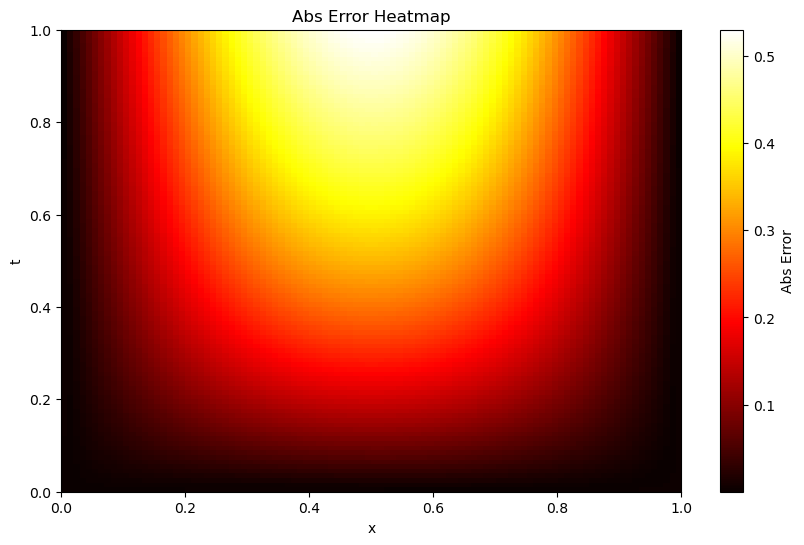

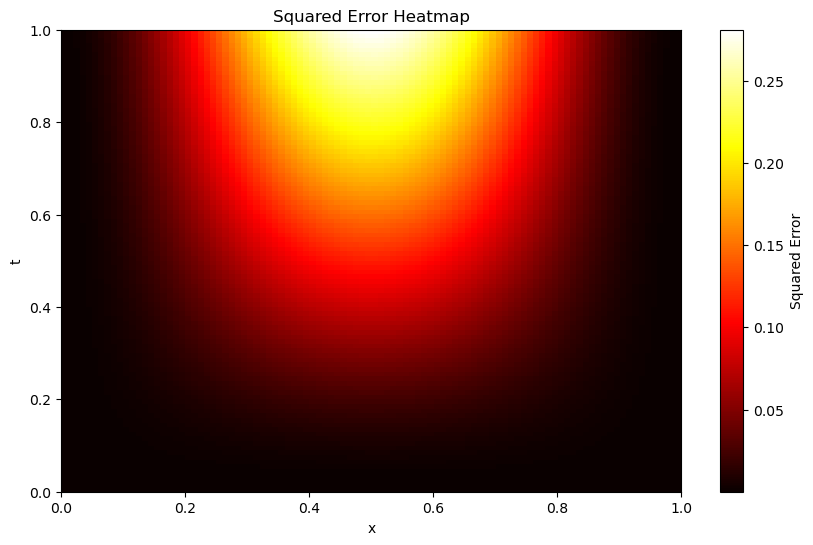

In [ ]:
def plot_error_heatmap(df, error_type='abs_error'):
    '''
    Plot a heatmap of the specified error type.

    Parameters:
    - df: DataFrame containing the error data.
    - error_type: The type of error to plot ('abs_error' or 'squared_error').
    '''
    plt.figure(figsize=(10, 6))
    # Create a pivot table for the heatmap
    pivot_table = df.pivot(index='t', columns='x', values=error_type)
    # Plot the heatmap
    im = plt.imshow(pivot_table, aspect='auto', cmap='hot', origin='lower',
                    extent=[pivot_table.columns.min(), pivot_table.columns.max(),
                            pivot_table.index.min(), pivot_table.index.max()])
    # Format the title and labels
    plt.colorbar(label=error_type.replace('_', ' ').title())
    plt.title(f'{error_type.replace("_", " ").title()} Heatmap')
    # Set the ticks and labels
    plt.xlabel('x')
    plt.ylabel('t')
    plt.show()

plot_error_heatmap(df, error_type='abs_error')
plot_error_heatmap(df, error_type='squared_error')